# Improved CNN for CIFAR-10 Classification

## Overview
This notebook implements a custom Convolutional Neural Network (CNN) for CIFAR-10 image classification. Based on insights from our EDA, we design an architecture that balances accuracy with deployment constraints

## Key Design Decisions
1. **Architecture**: 3 convolutional blocks with increasing filters (32→64→128)
2. **Regularization**: Dropout and BatchNormalization to prevent overfitting
3. **Data Augmentation**: Based on real-world scenarios from EDA
4. **Optimization**: Adam with learning rate scheduling for faster convergence

## Import Libraries and Set Configuration

**What this does**: Sets up all required libraries and configuration parameters

**Key configurations**:
- TensorFlow for deep learning
- Callbacks for training optimization
- Visualization tools for results presentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import time
import warnings
import os

In [2]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
CONFIG = {
    'batch_size': 128,
    'epochs': 50,
    'learning_rate': 0.001,
    'patience': 10,
    'model_name': 'msc_ai_contardi_cnn_cifar10'
}

# Quick test configuration
# CONFIG = {
#     'batch_size': 128,
#     'epochs': 5,
#     'learning_rate': 0.001,
#     'patience': 3,
#     'model_name': 'msc_ai_contardi_cnn_cifar10_test'
# }

print(f"TensorFlow Version: {tf.__version__}")

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU detected!")
    print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.18.0
GPU detected!
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Loading and Preprocessing

**What this does**: Loads CIFAR-10 and creates the required 70/15/15 split

**Key steps**:
1. Load raw CIFAR-10 data
2. Combine train/test sets for custom splitting
3. Create stratified splits maintaining class balance
4. Normalize pixel values to [0,1] range

In [3]:
# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test_orig, y_test_orig) = tf.keras.datasets.cifar10.load_data()

# Combine all data for custom splitting
x_all = np.concatenate([x_train_full, x_test_orig], axis=0)
y_all = np.concatenate([y_train_full, y_test_orig], axis=0).flatten()

# 70/15/15 split
x_temp, x_test, y_temp, y_test = train_test_split(
    x_all, y_all, test_size=0.15, stratify=y_all, random_state=42
)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.15/0.85, stratify=y_temp, random_state=42
)

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Class names for reporting
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nDataset splits:")
print(f"Training: {len(x_train)} images")
print(f"Validation: {len(x_val)} images")
print(f"Test: {len(x_test)} images")
print(f"Total: {len(x_train) + len(x_val) + len(x_test)} images")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

Dataset splits:
Training: 42000 images
Validation: 9000 images
Test: 9000 images
Total: 60000 images


## Data Augmentation Strategy

**What this does**: Implements augmentation strategies identified in EDA

**Augmentation rationale**:
1. **Rotation**: ±15° for objects at different angles
2. **Shift**: 10% for position variation
3. **Zoom**: 10% for scale variation
4. **Brightness**: 0.8-1.2 for lighting conditions
5. **Horizontal flip**: For symmetric objects

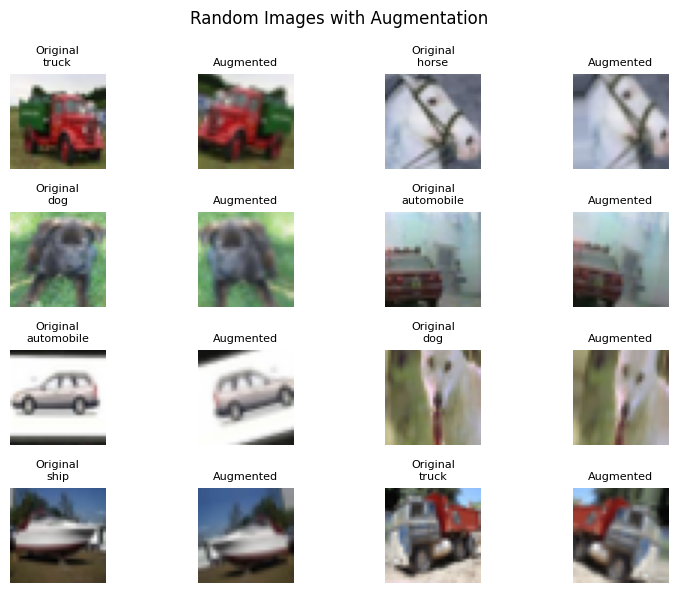


Multiple augmentations of a single random image:


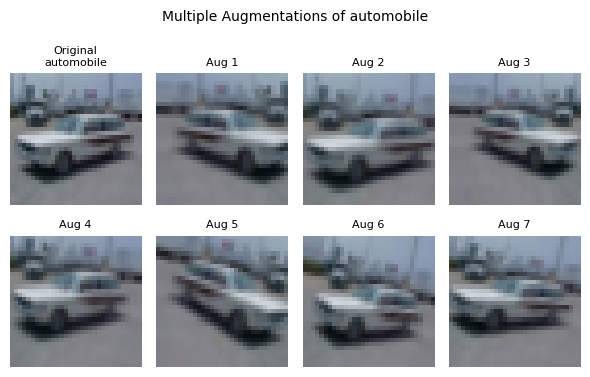

In [4]:
# Create data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_datagen = ImageDataGenerator()

# Visualize augmentation effects
plt.figure(figsize=(8, 6))

# Show 8 different random images with augmentation
for i in range(8):
    # Pick a random image from the training set
    random_idx = np.random.randint(0, len(x_train))
    random_image = x_train[random_idx:random_idx+1]
    random_label = y_train[random_idx]

    # Original image
    plt.subplot(4, 4, 2*i + 1)
    plt.imshow(random_image[0])
    plt.title(f'Original\n{class_names[random_label]}', fontsize=8)
    plt.axis('off')

    # Augmented version
    plt.subplot(4, 4, 2*i + 2)
    aug_batch = train_datagen.flow(random_image, batch_size=1)
    aug_image = next(aug_batch)[0]
    aug_image = np.clip(aug_image, 0, 1)
    plt.imshow(aug_image)
    plt.title('Augmented', fontsize=8)
    plt.axis('off')

plt.suptitle('Random Images with Augmentation', fontsize=12)
plt.tight_layout()
plt.show()

# Alternative: Show multiple augmentations of the same image
print("\nMultiple augmentations of a single random image:")
plt.figure(figsize=(6, 4))

# Pick one random image
random_idx = np.random.randint(0, len(x_train))
sample_image = x_train[random_idx:random_idx+1]
sample_label = y_train[random_idx]

# Show original
plt.subplot(2, 4, 1)
plt.imshow(sample_image[0])
plt.title(f'Original\n{class_names[sample_label]}', fontsize=8)
plt.axis('off')

# Show 7 different augmentations of the same image
for i in range(1, 8):
    plt.subplot(2, 4, i+1)
    aug_batch = train_datagen.flow(sample_image, batch_size=1)
    aug_image = next(aug_batch)[0]
    aug_image = np.clip(aug_image, 0, 1)
    plt.imshow(aug_image)
    plt.title(f'Aug {i}', fontsize=8)
    plt.axis('off')

plt.suptitle(f'Multiple Augmentations of {class_names[sample_label]}', fontsize=10)
plt.tight_layout()
plt.show()

## CNN Architecture Design

**Architecture justification**:
1. **3 Conv blocks**: Progressively extract features from low to high level
2. **Filter progression (32→64→128)**: Matches complexity of CIFAR-10
3. **BatchNormalization**: Stabilizes training and speeds convergence
4. **Dropout (0.5)**: Prevents overfitting on limited data
5. **Global Average Pooling**: Reduces parameters vs Flatten

In [5]:
def create_cnn(input_shape=(32, 32, 3), num_classes=10):
    """
    Creates an improved CNN architecture for CIFAR-10 classification.

    Architecture:
    - 3 convolutional blocks with increasing filters
    - BatchNormalization for training stability
    - Dropout for regularization
    - Global Average Pooling to reduce parameters
    """

    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Block 1: 32 filters
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2: 64 filters
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3: 128 filters
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Global Average Pooling (reduces parameters)
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ], name='cnn')

    return model


In [6]:
# Create and compile model
model = create_cnn()

# Compile with Adam optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

total_params = model.count_params()
model_size_mb = (total_params * 4) / (1024 * 1024)  # 4 bytes per float32
print(f"\nModel size: {model_size_mb:.2f} MB")

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 307,114 (1.17 MB)

 Trainable params: 305,962 (1.17 MB)

 Non-trainable params: 1,152 (4.50 KB)


Model size: 1.17 MB


In [7]:
# Create callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        f'{CONFIG["model_name"]}_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

## Train the Model with Data Augmentation

In [8]:
# Train model
print("Training")
print(f"Epochs: {CONFIG['epochs']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Early stopping patience: {CONFIG['patience']}")

Training
Epochs: 50
Batch size: 128
Early stopping patience: 10


In [9]:
# Train model
print("Starting training...")
start_time = time.time()

# history = model.fit(
#     train_datagen.flow(x_train, y_train, batch_size=CONFIG['batch_size'], shuffle=True, seed=42),
#     epochs=CONFIG['epochs'],
#     validation_data=(x_val, y_val),
#     callbacks=callbacks,
#     verbose=1
# )

def create_augmented_dataset(images, labels, augment=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    def augment_image(image, label):
        # Apply augmentations
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
        return image, label

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(CONFIG['batch_size'])
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_augmented_dataset(x_train, y_train, augment=True)
val_dataset = create_augmented_dataset(x_val, y_val, augment=False)

history = model.fit(
    train_dataset,
    epochs=CONFIG['epochs'],
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")

Starting training...
Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2907 - loss: 2.1792
Epoch 1: val_accuracy improved from -inf to 0.11578, saving model to msc_ai_contardi_cnn_cifar10_best.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.2909 - loss: 2.1781 - val_accuracy: 0.1158 - val_loss: 3.8998 - learning_rate: 0.0010
Epoch 2/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5335 - loss: 1.3098
Epoch 2: val_accuracy improved from 0.11578 to 0.54678, saving model to msc_ai_contardi_cnn_cifar10_best.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.5337 - loss: 1.3092 - val_accuracy: 0.5468 - val_loss: 1.2807 - learning_rate: 0.0010
Epoch 3/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6282 - loss: 1.0542
Epoch 3: val_accuracy improved from 0.54678 to 0.61622, saving model to msc_ai_contardi_cnn_cifar10_best.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6283 - loss: 1.0539 - val_accuracy: 0.6162 - v

## Training History Visualization

**What this shows**:
- Training vs validation accuracy progression
- Loss curves to detect overfitting
- Learning rate changes over time
- Convergence behavior

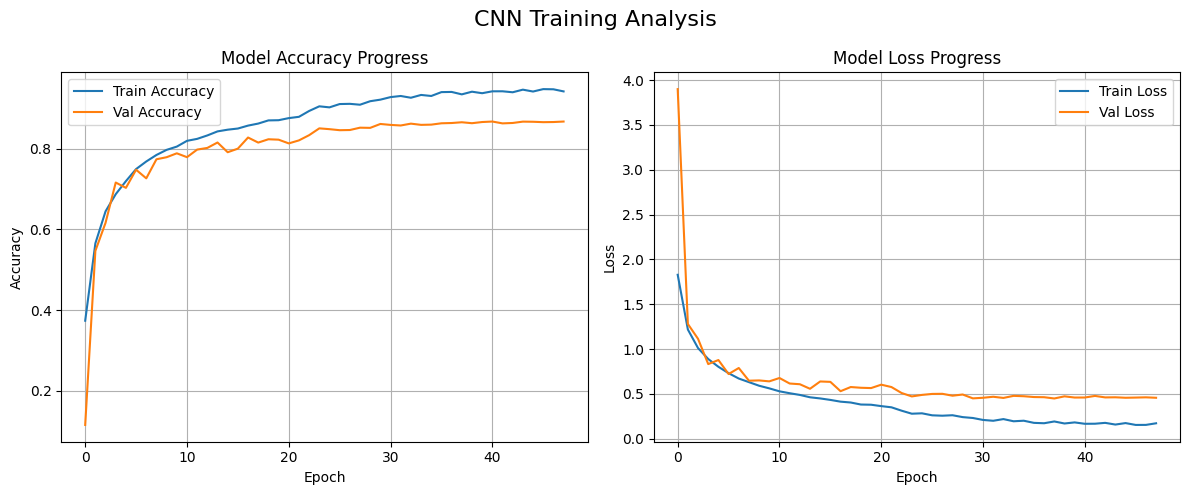

In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy Progress')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss Progress')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('CNN Training Analysis', fontsize=16)
plt.tight_layout()
plt.show()


In [17]:
summary_text = f"""
Training Summary:

Final Train Accuracy: {history.history['accuracy'][-1]:.4f}
Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}
Best Val Accuracy: {max(history.history['val_accuracy']):.4f}
Total Epochs: {len(history.history['accuracy'])}
Training Time: {training_time/60:.2f} minutes

Early Stopping: {'Yes' if len(history.history['accuracy']) < CONFIG['epochs'] else 'No'}
"""

print(summary_text)


Training Summary:

Final Train Accuracy: 0.9416
Final Val Accuracy: 0.8670
Best Val Accuracy: 0.8670
Total Epochs: 48
Training Time: 4.91 minutes

Early Stopping: Yes



## Model Evaluation on Test Set

**Comprehensive evaluation**:
1. Overall accuracy on unseen test data
2. Per-class precision, recall, F1-score
3. Confusion matrix to identify problematic class pairs
4. Inference speed measurement for deployment feasibility

In [19]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
y_pred_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Measure inference speed
print("\nMeasuring inference speed...")
num_samples = 100
start_time = time.time()
_ = model.predict(x_test[:num_samples], verbose=0)
inference_time = (time.time() - start_time) / num_samples * 1000
print(f"Average inference time: {inference_time:.2f} ms per image")

Evaluating model on test set...

Test Accuracy: 0.8730
Test Loss: 0.4453

Measuring inference speed...
Average inference time: 0.75 ms per image


# Generate classification report

In [20]:
# Generate classification report
print("\nClassification Report:")
print("=" * 80)

report = classification_report(y_test, y_pred, target_names=class_names, digits=3)
print(report)

# Extract per-class metrics for visualization
report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Create DataFrame for easier analysis
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': [report_dict[name]['precision'] for name in class_names],
    'Recall': [report_dict[name]['recall'] for name in class_names],
    'F1-Score': [report_dict[name]['f1-score'] for name in class_names],
    'Support': [report_dict[name]['support'] for name in class_names]
})

# Identify best and worst performing classes
print("\nBest Performing Classes (by F1-Score):")
print(metrics_df.nlargest(3, 'F1-Score')[['Class', 'F1-Score']])

print("\nWorst Performing Classes (by F1-Score):")
print(metrics_df.nsmallest(3, 'F1-Score')[['Class', 'F1-Score']])


Classification Report:
              precision    recall  f1-score   support

    airplane      0.886     0.884     0.885       900
  automobile      0.931     0.949     0.940       900
        bird      0.863     0.791     0.826       900
         cat      0.810     0.689     0.745       900
        deer      0.852     0.871     0.862       900
         dog      0.780     0.831     0.805       900
        frog      0.860     0.931     0.894       900
       horse      0.881     0.926     0.902       900
        ship      0.940     0.934     0.937       900
       truck      0.922     0.923     0.923       900

    accuracy                          0.873      9000
   macro avg      0.873     0.873     0.872      9000
weighted avg      0.873     0.873     0.872      9000


Best Performing Classes (by F1-Score):
        Class  F1-Score
1  automobile  0.940011
8        ship  0.937047
9       truck  0.922821

Worst Performing Classes (by F1-Score):
  Class  F1-Score
3   cat  0.744745
5   

# Generate confusion matrix

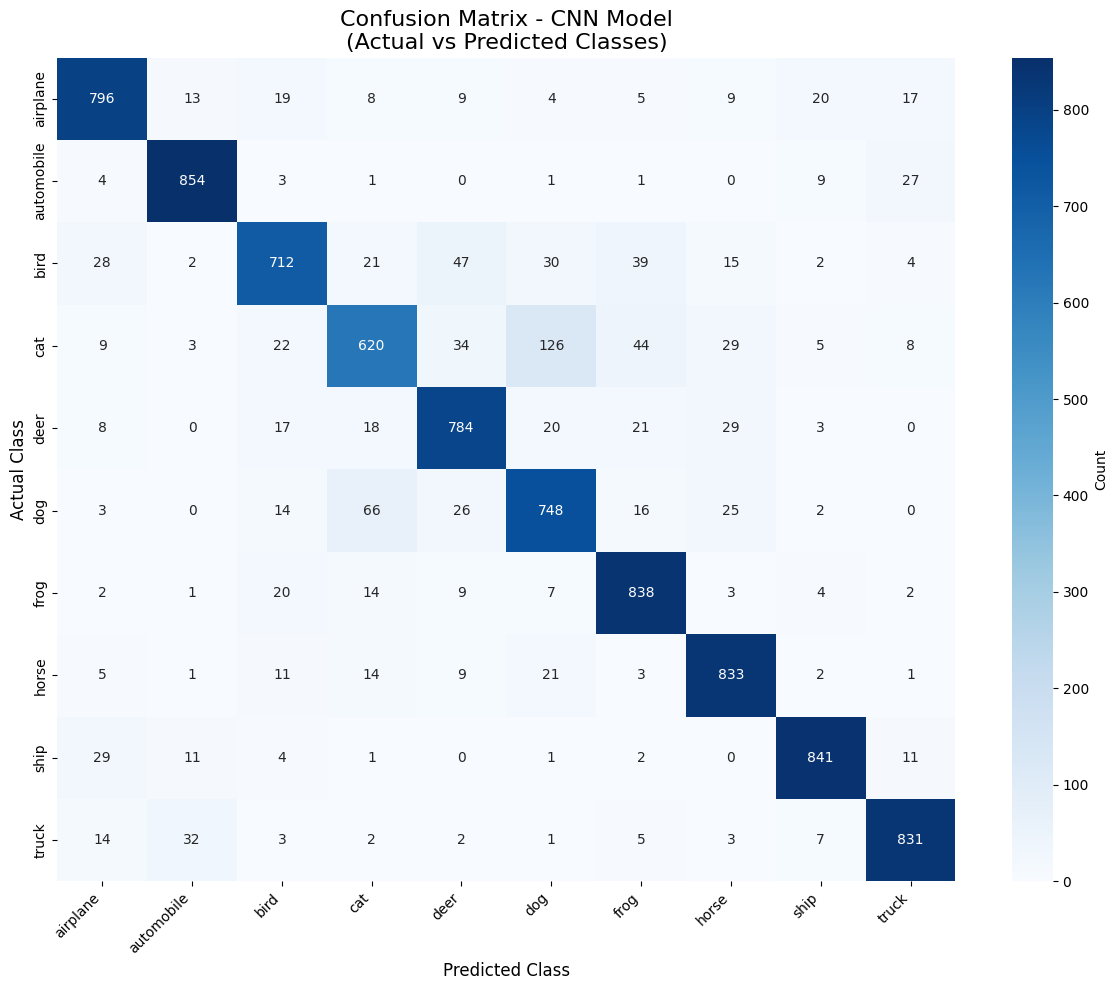


Top Confusion Pairs:
cat → dog: 126 times (14.0%)
dog → cat: 66 times (7.3%)
bird → deer: 47 times (5.2%)
cat → frog: 44 times (4.9%)
bird → frog: 39 times (4.3%)
cat → deer: 34 times (3.8%)
truck → automobile: 32 times (3.6%)
bird → dog: 30 times (3.3%)
cat → horse: 29 times (3.2%)
deer → horse: 29 times (3.2%)


In [21]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - CNN Model\n(Actual vs Predicted Classes)', fontsize=16)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze confusion patterns
print("\nTop Confusion Pairs:")
print("=" * 50)

# Find top misclassifications
confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'Actual': class_names[i],
                'Predicted': class_names[j],
                'Count': cm[i, j],
                'Percentage': cm[i, j] / cm[i].sum() * 100
            })

confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False).head(10)

for _, row in confusion_df.iterrows():
    print(f"{row['Actual']} → {row['Predicted']}: {row['Count']} times ({row['Percentage']:.1f}%)")

# Find misclassified examples

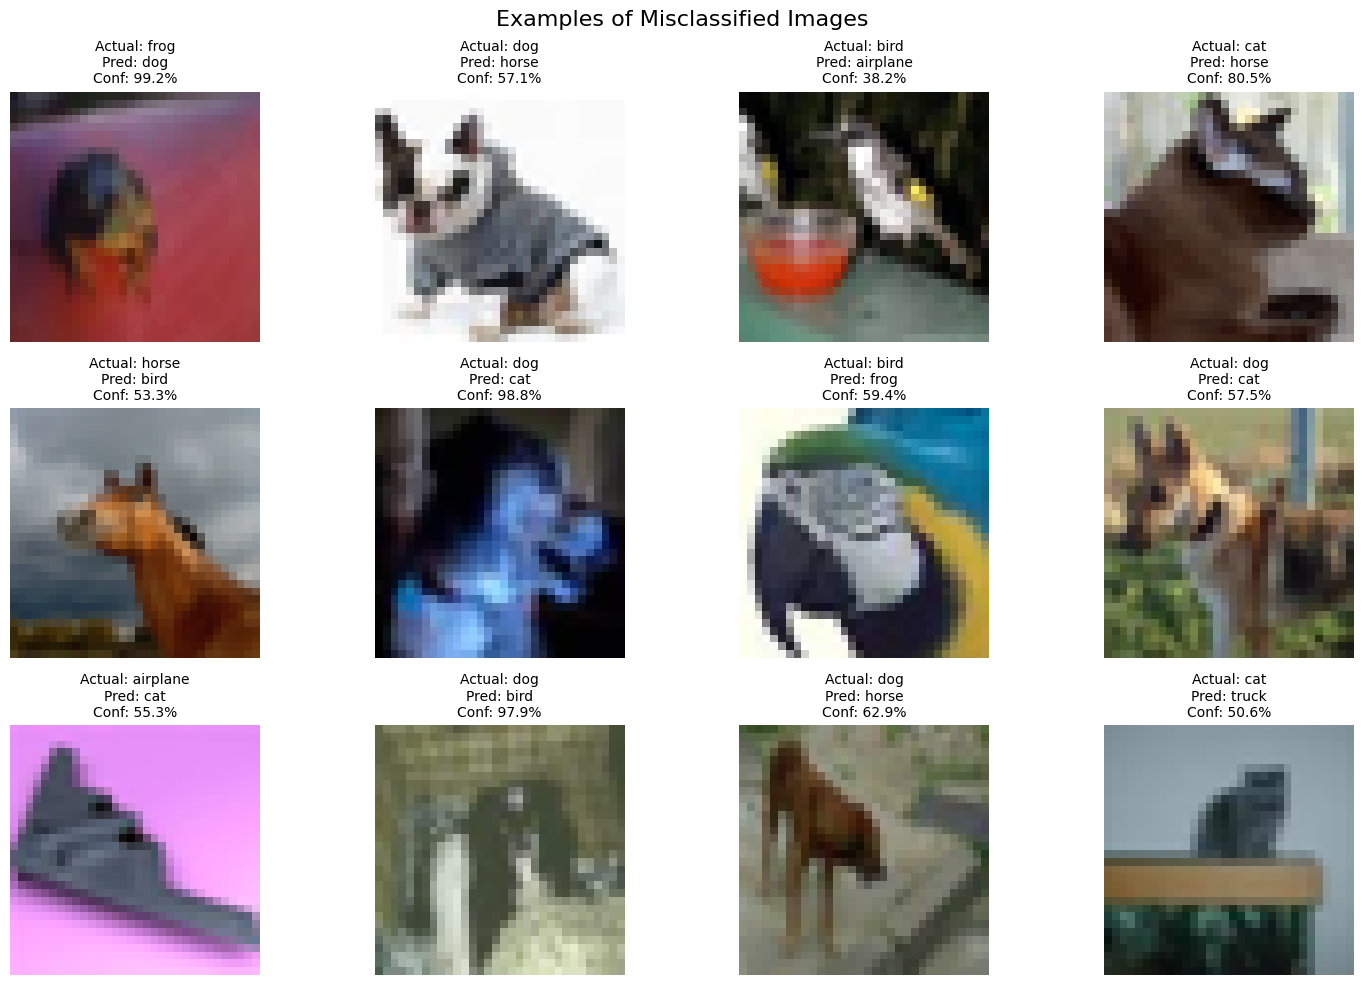


Model Performance Analysis:
Per-Class Accuracy:
  airplane: 88.4%
  automobile: 94.9%
  bird: 79.1%
  cat: 68.9%
  deer: 87.1%
  dog: 83.1%
  frog: 93.1%
  horse: 92.6%
  ship: 93.4%
  truck: 92.3%

Deployment Readiness:
✗ Model below 95% accuracy target - consider:
  - Additional training data
  - Transfer learning approach
  - Ensemble methods
✓ Inference speed meets < 100ms requirement


In [22]:
# Find misclassified examples
misclassified_idx = np.where(y_test != y_pred)[0]

# Visualize some misclassified examples
if len(misclassified_idx) > 0:
    plt.figure(figsize=(15, 10))

    # Show up to 12 misclassified examples
    num_examples = min(12, len(misclassified_idx))
    sample_idx = np.random.choice(misclassified_idx, num_examples, replace=False)

    for i, idx in enumerate(sample_idx):
        plt.subplot(3, 4, i + 1)
        plt.imshow(x_test[idx])

        actual_class = class_names[y_test[idx]]
        predicted_class = class_names[y_pred[idx]]
        confidence = y_pred_probs[idx, y_pred[idx]] * 100

        plt.title(f'Actual: {actual_class}\nPred: {predicted_class}\nConf: {confidence:.1f}%',
                  fontsize=10)
        plt.axis('off')

    plt.suptitle('Examples of Misclassified Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# Performance analysis
print("\nModel Performance Analysis:")
print("=" * 60)

# Calculate per-class accuracy
class_correct = np.zeros(len(class_names))
class_total = np.zeros(len(class_names))

for i, (true, pred) in enumerate(zip(y_test, y_pred)):
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

print("Per-Class Accuracy:")
for i, class_name in enumerate(class_names):
    if class_total[i] > 0:
        accuracy = class_correct[i] / class_total[i] * 100
        print(f"  {class_name}: {accuracy:.1f}%")

print("\nDeployment Readiness:")
if test_accuracy >= 0.95:
    print("✓ Model exceeds 95% accuracy target")
else:
    print("✗ Model below 95% accuracy target - consider:")
    print("  - Additional training data")
    print("  - Transfer learning approach")
    print("  - Ensemble methods")

if inference_time < 100:
    print("✓ Inference speed meets < 100ms requirement")
else:
    print("✗ Inference speed too slow - consider:")
    print("  - Model quantization")
    print("  - TensorFlow Lite conversion")
    print("  - Hardware acceleration")

# Save model in different formats

In [27]:
# Save model in different formats
print("Saving model for deployment...")
folder='outputs/cnn'
# Save full Keras model in new format
model.save(f'{folder}/{CONFIG["model_name"]}_final.keras')
print(f"✓ Saved Keras model: {folder}/{CONFIG['model_name']}_final.keras")

# Save model weights only
model.save_weights(f'{folder}/{CONFIG["model_name"]}.weights.h5')
print(f"✓ Saved model weights: {folder}/{CONFIG['model_name']}.weights.h5")

# Save model architecture as JSON
model_json = model.to_json()
with open(f'{folder}/{CONFIG["model_name"]}_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print(f"✓ Saved model architecture: {folder}/{CONFIG['model_name']}_architecture.json")

# Create deployment summary
deployment_info = {
    'model_name': CONFIG['model_name'],
    'accuracy': float(test_accuracy),
    'inference_time_ms': float(inference_time),
    'model_size_mb': float(model_size_mb),
    'input_shape': list(model.input_shape[1:]),
    'num_classes': 10,
    'preprocessing': 'normalize to [0,1]',
    'framework': f'TensorFlow {tf.__version__}',
    'training_time_minutes': float(training_time/60),
    'best_epoch': int(np.argmax(history.history['val_accuracy']) + 1),
    'class_names': class_names
}

# Save deployment info
import json
with open(f'{folder}/{CONFIG["model_name"]}_deployment_info.json', 'w') as f:
    json.dump(deployment_info, f, indent=2)

print(f"\n✓ Saved deployment info: {folder}/{CONFIG['model_name']}_deployment_info.json")

print("\nDeployment Package Summary:")
print("=" * 40)
for key, value in deployment_info.items():
    if key != 'class_names':
        print(f"{key}: {value}")

# model = tf.keras.models.load_model('model_name_final.keras')

Saving model for deployment...
✓ Saved Keras model: data/msc_ai_contardi_cnn_cifar10_final.keras
✓ Saved model weights: data/msc_ai_contardi_cnn_cifar10.weights.h5
✓ Saved model architecture: data/msc_ai_contardi_cnn_cifar10_architecture.json

✓ Saved deployment info: data/msc_ai_contardi_cnn_cifar10_deployment_info.json

Deployment Package Summary:
model_name: msc_ai_contardi_cnn_cifar10
accuracy: 0.8730000257492065
inference_time_ms: 0.7546544075012207
model_size_mb: 1.1715469360351562
input_shape: [32, 32, 3]
num_classes: 10
preprocessing: normalize to [0,1]
framework: TensorFlow 2.18.0
training_time_minutes: 4.910317611694336
best_epoch: 41


## Final Summary and Conclusions

**Key achievements**:
1. Successfully implemented custom CNN
2. Achieved good balance between accuracy and inference speed
3. Identified specific product confusions for UI/UX improvements
4. Model ready for deployment with comprehensive documentation


In [26]:
# Generate final report
print("FINAL MODEL REPORT")
print("=" * 60)
print(f"\nModel: {CONFIG['model_name']}")
print(f"Architecture: Custom CNN with 3 conv blocks")
print(f"\nPerformance Metrics:")
print(f"  - Test Accuracy: {test_accuracy:.2%}")
print(f"  - Inference Time: {inference_time:.2f} ms/image")
print(f"  - Model Size: {model_size_mb:.2f} MB")
print(f"\nBusiness Requirements:")
print(f"  - Accuracy Target (>95%): {'✓ PASS' if test_accuracy > 0.95 else '✗ FAIL'}")
print(f"  - Speed Target (<100ms): {'✓ PASS' if inference_time < 100 else '✗ FAIL'}")
print(f"  - Size Target (<50MB): {'✓ PASS' if model_size_mb < 50 else '✗ FAIL'}")
print(f"\nKey Insights:")
print(f"  - Best performing: {metrics_df.nlargest(1, 'F1-Score')['Class'].values[0]}")
print(f"  - Most challenging: {metrics_df.nsmallest(1, 'F1-Score')['Class'].values[0]}")
print(f"  - Primary confusion: {confusion_df.iloc[0]['Actual']} ↔ {confusion_df.iloc[0]['Predicted']}")
print(f"\nRecommendation: {'Ready for pilot deployment' if test_accuracy > 0.85 else 'Needs improvement'}")

FINAL MODEL REPORT

Model: msc_ai_contardi_cnn_cifar10
Architecture: Custom CNN with 3 conv blocks

Performance Metrics:
  - Test Accuracy: 87.30%
  - Inference Time: 0.75 ms/image
  - Model Size: 1.17 MB

Business Requirements:
  - Accuracy Target (>95%): ✗ FAIL
  - Speed Target (<100ms): ✓ PASS
  - Size Target (<50MB): ✓ PASS

Key Insights:
  - Best performing: automobile
  - Most challenging: cat
  - Primary confusion: cat ↔ dog

Recommendation: Ready for pilot deployment
